# nbjob - Using Jupyter notebooks for machine learning research
*Implements experiment management and lightweight version control.*

* Home: http://nikitakitaev.com/nbjob
* GitHub: http://github.com/nikitakit/nbjob

`nbjob` is a Python library that enhances Jupyter notebooks.

Features:
* Dispatch jobs from Jupyter Notebooks to an ipyparallel cluster
* Designed for long-running jobs, such as training a neural network for greater than a day
* Store intermediate and final job results
* Keep reproducible source code backups for all jobs
* Run analyses on job results
* Easily run a series of jobs related jobs with different hyperparameters

## Background

### Problem
The Jupyter notebook is a powerful tool for interacting with data. It lets you visualize what is happening while developing algorithms that process the data.

At the same time, the Jupyter notebook is a way of sharing a computational narrative: that is, slowly building up pieces of an algorithm and explaining how they work on data.

However, this view skips the entire process in between. Here Jupyter is limited in two key ways: it doesn't provide a good architecture for farming out parallel jobs when pickle fails, and it doesn't have version control that's well-adapted to the domain of algorithms research.

#### Job architecture

One key feature of the notebook is that it encourages keeping a lot of information stored as datastructures in memory, as opposed to stored as files on disk. So you end up having data structures that aren't serialized anywhere, and that maybe can't be regenerated because the code cells leading to them have been deleted. You also have functions that exist only in the memory of the notebook, and maybe as source code somewhere inside a cell.

This makes it hard to transmit these datastructures to other machines as jobs. Objects in memory which are executable (like functions) or rely on interpreter state (like generators) are not guaranteed to be portable, and in many cases can't be sent across machines. Details of the Python pickle implementation impose further limitations.

#### Version control

A notebook in the process of being written may be filled with one-time code to visualize a particular piece of data, that will never be needed again. It may also be highly nonlinear, i.e. just executing the notebook from the top down starting with a clean slate may not even run. Sometimes code may be changed in place, obscuring old versions.

Jupyter provides checkpointing as a backup against crashes, but this only covers one use of version control. If a piece of code is deleted, and a researcher wants to remember what it did months down the line, this is not well-supported by a simple versioning setup.

Similarly, research often involves considering many different code variations in parallel. Whereas for well-understood domains software engineers can have a linear revision history that slowly adds functionality, it is not unnatural research to have many branching paths. Most of these will be swiftly abandoned, but sometimes need to be dug up at a much later date.

### Solution

These are symptoms of the same problem: storing code and data in memory instead of on-disk. Even if the full history leading to the current state is theoretically available (e.g. in IPython history logs), it is not easy to use.

A common solution to this problem is well known: make sure that jobs are submitted in reproducible source-code form, and store the code of any job ever submitted. This solves portability across machines, and versioning any code that may be of interest. Frameworks that do this typically rely on a combination of existing version control systems, shell scripts, and archive files.

What makes it hard to adapt the notebook to this kind of workflow out-of-the-box is that a notebook might contain a mix of algorithmic and exploratory code. The algorithmic code is the key to running reproducible jobs, but the exploratory code is there to help the author make sense of the results and find bugs. It is usually this exploratory code that is unreproducible.

The key observation is: the author knows which code is exploratory, and which code isn't. Also, the algorithmic code is typically fairly concise, and also more reproducible than the exploratory sections.

So this is the general flavor of the proposal: the author annotates algorithmic code, runs the code in jobs (possibly on remote clusters), and this framework keep tracks of versioning the result.

### Other things along the way

Other features we pick up along the way:
* Having jobs run report intermediate and final results, and storing them
* Running analyses on the results
* Integration with ipycluster

## About this framework

This framework, called `nbjob`, is still heavily a work in progress. It is in flux as I adapt it to my personal research needs.

Comments welcome.

## Mini-Tutorial

### Installation

WARNING: this package is in a pre-alpha state. Installation is only available via GitHub.

To install:

In [ ]:
!pip install git+git://github.com/nikitakit/nbjob.git@master

### Dependencies
#### ipyparallel
`nbjob` sends out jobs to workers that are part of an IPython Cluster. The `ipyparallel` module is installed as a dependency of `nbjob`, but the cluster itself must be launched separately. For simple workloads, the cluster can be started on the local machine (with 1 worker per CPU), using the `IPython Clusters` tab in the Jupyter notebook.

To install the `IPython Clusters` tab in Jupyter Notebook, add this to your `jupyter_notebook_config.py`:

```python
c.NotebookApp.server_extensions.append('ipyparallel.nbextension')
```

See the [documentation on configuring the notebook server](https://jupyter-notebook.readthedocs.org/en/latest/public_server.html)
to find your config or setup your initial `jupyter_notebook_config.py`.

#### MongoDB
The `pymongo` wrapper is installed as a dependency of `nbjob`, but need to also install and launch an actual MongoDB database. See [the MongoDB website](https://www.mongodb.org/downloads#production) for instructions. Currently, `nbjob` expects MongoDB to be running locally with the default port configuration.

### Introducing Snippets

We have Snippet Collector objects, which you can use to mark cells as non-experimental

In [1]:
from nbjob import SnippetCollector
sc = SnippetCollector()

You can collect functions and classes by attaching decorators to them

In [2]:
@sc
def norm(val):
    import math
    return math.sqrt(val.x**2 + val.y**2)

@sc
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

You can also collect pieces of code (which run locally to verify the code is correct)

In [3]:
%%snip sc
origin = Point(0., 0.)

Finally, you can spin up jobs relating to these snippets

This first requires connecting to both the database (which stores job results), and an IPython cluster

In [4]:
from nbjob import DBWrapper
db_wrapper = DBWrapper()

import ipyparallel as ipp
rc = ipp.Client()

worker_view = rc[0] # Pointer to worker 0 in the cluster

Then we can proceed to running jobs on a particular worker in the cluster

In [5]:
job = db_wrapper.create_job(
    worker_view, ['print(norm(origin))'],
    sc
    )
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

RemoteError: KeyError('_6debf1499c324757a38955be25c8e98b_f')

You may see a Traceback similar to `KeyError: '_6debf1499c324757a38955be25c8e98b_f'`. To the best of my knowledge, this relates to a bug in ipyparallel, and does not impact nbjob.

### Running jobs from multiple snippets

We support running multiple snippets in series

In [6]:
sc2 = SnippetCollector()

In [7]:
@sc2
def distance(p1, p2):
    diff = Point(p1.x - p2.x, p1.y - p2.y)
    return norm(diff)

In [8]:
%%snip sc2
a = Point(1., 2.)
b = Point(3., 0.)

Now we can start a job to run the code. This is designed to be interactive, so you will get a widget to review the job before it is submitted

In [9]:
job = db_wrapper.create_job(
    worker_view, ['print(distance(a, b))'],
    sc, sc2 # Note that we use both here!
    )
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

RemoteError: KeyError('_b0737ae37de44ebb950c9d8e92d6d1c0_args')

### Specifying parameters

We also have support for parameters

In [10]:
from nbjob import ParamLogger
params = ParamLogger()
params.x = 5
params.y = 5

In [11]:
%%snip sc2
c = Point(params.x, params.y)

When you run the code below, you will be prompted to adjust the parameters for that particular run, if desired.

In [12]:
job = db_wrapper.create_job(
    worker_view, ['distance(a, b)'],
    sc, sc2,
    params=params # Here we introduce the parameters
    )
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

RemoteError: KeyError('_c4128854d5c4448daba2896bfe3d81f8_args')

### Viewing the jobs dashboard

In [13]:
# Unfortunately, widgets are not rendered in the HTML version of this page
# You will need to download and run this notebook to see the dashboard.
import nbjob
nbjob.make_default_dashboard()

### Checkpointing and running analyses

This is particular to machine learning, where we have intermediate values of model parameters and we may want to evaluate something over time

Let's imagine the following dummy setup, where we're training a single parameter value to approximate the number `5.0`. However, as a parallel to machine learning, we don't do it in one step. Instead, we have a procedure where the number iteratively approaches its final value.

Checkpointing is done through a job tracker, stored in the `jobtracker` global variable. The `jobtracker` variable is automatically set on remote workers, but on the local machine we need to manually instantiate it with a dummy.

In [16]:
from nbjob import DummyJobtracker
jobtracker = DummyJobtracker()

In [17]:
sc3 = SnippetCollector()

In [18]:
%%snip sc3
iteration = 0
param_values = [0]
jobtracker.register_checkpointer('iteration') # Save this for intermediate results
jobtracker.register_checkpointer('param_values') # Save this for intermediate results

def train():
    global iteration, params
    while abs(param_values[0] - 5.0) > 1e-5:
        iteration += 1
        param_values[0] += 0.5 * (5.0 - param_values[0]) # Iteratively approach 5
        jobtracker.checkpoint() # Save the value of iteration and params
        
# The jobtracker variable is a global variable available in all workers, that provides an interface
# for communicating back with the database

In [19]:
job = db_wrapper.create_job(
    worker_view, ['train()'],
    sc3,
    )
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

RemoteError: KeyError('_7a17343596e64aba8bc8395d0ffbc8ea_f')

Here we have been checkpointing at every training iteration, and we have made it so that the iteration and parameter values are logged at each checkpoint. We can then analyze the incremental results from running our job.

In [20]:
def test_performance():
    global iteration, param_values
    return {'iteration':iteration,
           'error': abs(param_values[0] - 5.0)}

analyzer = db_wrapper.create_analyzer(
    worker_view,
    job,
    [test_performance])
analyzer.result

<AsyncResult: remote_start_analyzer>

RemoteError: KeyError('_6af27d426dc448ffa9595713fa454661_kwargs')

The analyzer gives us a list of dictionaries, each of which has `iteration` and `error` as keys. We can use them to make a plot of error rate over time.

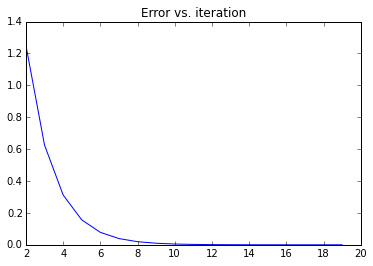

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

xs = []
ys = []
for d in analyzer.get_results():
    xs.append(d['iteration'])
    ys.append(d['error'])

plt.title('Error vs. iteration')
plt.plot(xs, ys)

The analysis gets a snapshot of the system with the checkpointed variables correctly restored. This means that if the parameters of a neural network are checkpointed, the analysis can run the network on validation or testing data.